# bardensr

```
Multiplexing (sometimes contracted to muxing) is a method 
by which multiple analog or digital signals are combined 
into one signal over a shared medium.

-- Wikipedia
```

The `bardensr` (barcode dexmixing through non-negative spatial regression) package is a collection of tools for modeling linearly multiplexed observations.  There is some true signal we are interested in, but our observations are some noisy linear mixture of those signals.  

### imports

Before we begin, let's import the packages we'll need. 

In [1]:
%load_ext autoreload
%autoreload 2
import bardensr
import bardensr.benchmarks
import matplotlib.pylab as plt
import IPython.display
import bardensr.barcodesfirst
import numpy as np
import bardensr.singlefov.denselearner
import scipy as sp
import scipy.ndimage
import tensorflow as tf

### data

To start with, let's look at an example of the kind of problem bardensr is designed for.  The bardensr package comes with a few benchmarks which can be used to examine performance.  Let's load one of them (the default) --

In [2]:
bench=bardensr.load_example('ab701a5a-2dc3-11eb-9890-0242ac110002')

This is a spatial transcriptomics benchmark.  It is from a BARseq experiment with 7 rounds and 4 channels.  For detailed information on this experiment, check out the barseq paper, https://github.com/jacksonloper/bardensr/paper.pdf.  

Here's a brief summary: in typical spatial transcriptomics experiment, the task is to locate and identify RNA molecules in a tissue.  To do so, we take the following steps:

1. Chemically attach special probes to these RNA molecules.  Different types of RNA each attach to different kinds of probes.
1. Build up these special probes into slightly bigger objects called 'rolonies.'  
1. Take many images of the tissue under different chemical configurations.  Each image is taken with multiple channels (typically 4).  The chemistry is designed so that different kinds of probes light up in different channels each time.  The pattern by which a given rolony lights up over the different images is called the **barcode** associated with that kind of rolony.  

Finally, we must analyze these images.  The primary analysis task is to take this stack of images and recover two things:
* the positions of the rolonies
* the barcodes associated with each rolony

The data in this benchmark covers a small field of view (1 x 200 x 200 voxels), and it has three important parts:

In [3]:
print("1. The data X -- a tensor with shape",bench.X.shape)
print("2. The codebook B -- a tensor with shape",bench.codebook.shape)
print("3. The ground-truth positions of the rolines -- a dataframe with keys",bench.rolonies.keys())

1. The data X -- a tensor with shape (7, 4, 1, 200, 200)
2. The codebook B -- a tensor with shape (7, 4, 65)
3. The ground-truth positions of the rolines -- a dataframe with keys Index(['j', 'm0', 'm1', 'm2', 'remarks', 'status'], dtype='object')


Let's start by taking a look what this data looks like.  There are different ways to visualize this.

OPTION 1.  `plot_rbc` gives a convenient way to make grids of plots where each row represents a different channel and each column represents a different round of imaging.  In this case we will get 28 different plots -- but emember that *all 28* of these plots are indicating fluorescence identified in the *same* region of tissue.  Each plot represents the same tissue under different chemical contexts and different lighting conditions.  Let's see what we find:

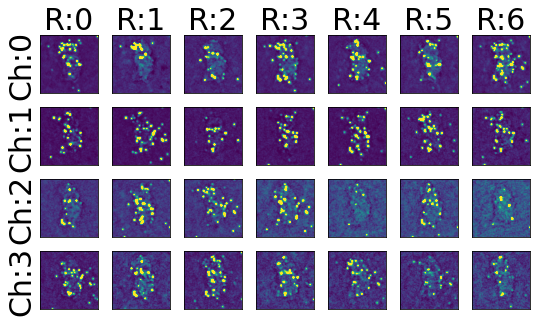

In [4]:
import bardensr.plotting
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,:],vmax=10)
bardensr.plotting.plot_rbc(7,4,go,sz=1,sideways=True,notick=True)

OPTION 2. We can also visualize the data using animated gifs.  Here we get one image per round, with each channel represented using a colorization scheme.

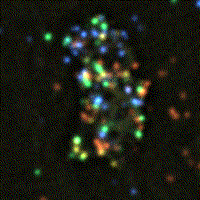

In [5]:
IPython.display.Image(bardensr.plotting.gify(bench.X[:,:,0]),width=250)

Either way we see pretty clearly that this region of data has a few prominent spots in it.  Let's zero in on just one of them:

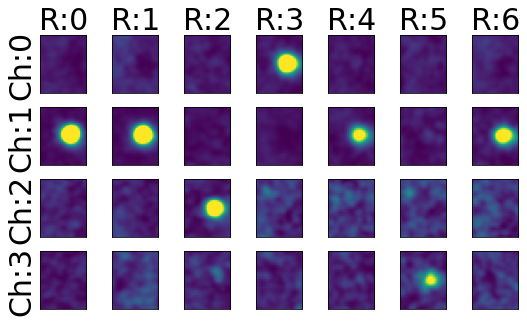

In [6]:
import bardensr.plotting
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,25:50,35:55],vmax=10)
bardensr.plotting.plot_rbc(7,4,go,sz=1,sideways=True,notick=True)

In [7]:
IPython.display.Image(bardensr.plotting.gify(bench.X[:,:,0,25:50,35:55]),width=250)

If we want to look at only a *single voxel* we can look at it with a simple heatmap:

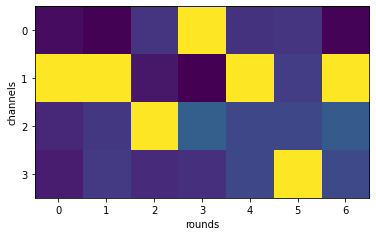

In [8]:
plt.imshow(bench.X[:,:,0,37,47].T,vmax=10)
plt.xlabel("rounds")
plt.ylabel("channels"); plt.yticks(range(4));

At this voxel, we can see that the tissue shows up brightly only in very specific images.  Specifically it shows up in channel 1, then channel 1 again, then channel 2, then channel 0, then channel 3, then channel 1.  This turns out to correspond to the 20th barcode in this experiments' codebook:

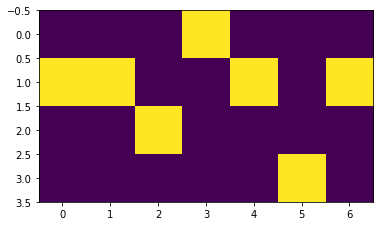

In [9]:
plt.imshow(bench.codebook[:,:,20].T)

In [10]:
# we can identify barcodes quickly using this convenience function:
print("rolonies which show up in channels 1120131 correspond to barcode",
      bardensr.benchmarks.query_onehot_codebook(bench.codebook,'1120131')[0])

rolonies which show up in channels 1120131 correspond to barcode 20


### analyzing this data (the simple way)

The simplest way to analyze this data is to look at every single voxel and see if it corresponds to one of the barcodes.  We call this the "barcodes first" approach, and have some simple code which implements it at blazing-fast speeds in tensorflow (thereby allowing GPU acceleration if available).  When the data is very sparse, this works great.

First, for every voxel and every barcode we compute the agreement between that voxel and that barcode (as measured by something like a normalized correlation):

In [11]:
densities=bardensr.barcodesfirst.build_density(bench.X,bench.codebook)
print(densities.shape) # <-- size-of-data x J

(1, 200, 200, 65)


We can visualize this over many voxels and many barcodes.  Below, for each of several barcodes, we visualize the agreement over a region of voxels:

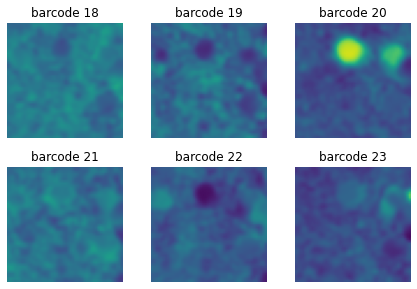

In [12]:
with bardensr.plotting.AnimAcross(sz=2) as a:
    for j in [18,19,20,21,22,23]:
        a(f'barcode {j}')
        plt.imshow(densities[0,25:75,25:75,j],vmin=0,vmax=1)
        plt.axis('off')

We can see that in this region of voxels, barcode 20 has very strong agreement in one place.  We can use this agreement as a criteria for deciding where or not there was a rolony of a given type in each location.  In particular, using a simple peak calling approach we can identify the positions of many of the rolonies in the data.

In [1]:
thresh=.75
result=bardensr.barcodesfirst.peak_call(densities,3,thresh)
result

NameError: name 'bardensr' is not defined

The result is a pandas dataframe with one row for each rolony.  The first three columns indicate the estimated spatial  position of the rolony, and the last column indicates the barcode that it is assocaited with.

### looking at the accuracy


We can compare this dataframe with the groundtruth.  This ground truth has been painstakingly constructed, one rolony at a time, and is stored in the benchmark.  To do so we must specify a "radius of wiggle" -- if the benchmark says theres a rolony at once position but our result says there's a rolony just one voxel away, we don't want to count that as a failure.  A radius of 5 is pretty reasonable for this data: 

In [14]:
comparison=bench.fpfn(result,5)
print("How many false positive?",comparison.fp) # <-- spots that this simple method found that aren't real
print("How many false negatives?",comparison.fn) # <-- spots that this simple method failed to find

How many false positive? 3
How many false negatives? 7


We can look at the failure modes of this simple method.

**FALSE POSITIVE EXAMPLE**

The simple method thought there was a rolony here with barcode 12


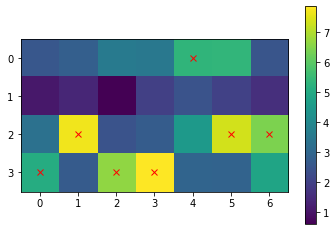

In [15]:
locals().update(dict(comparison.fp_rolonies.iloc[0]))
print("The simple method thought there was a rolony here with barcode",j)
plt.imshow(bench.X[:,:,0,m1,m2].T)
plt.plot(*np.where(bench.codebook[:,:,j]),'rx');
plt.colorbar();

But this is probably false positive.  If we look at the area round here we see that this signal is really quite small in absolute terms, and is probably due to spurious signal from nearby rolonies.

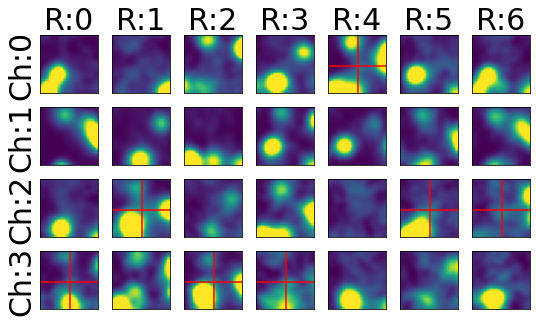

In [16]:
locals().update(dict(comparison.fp_rolonies.iloc[0]))
import bardensr.plotting
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,m1-10:m1+10,m2-10:m2+10],vmax=15)
    if bench.codebook[r,c,j]:
        plt.axhline(10,color='red')
        plt.axvline(10,color='red')
bardensr.plotting.plot_rbc(7,4,go,sz=1,sideways=True,notick=True)

**FALSE NEGATIVE EXAMPLE**

There's a rolony here with barcode 25 but this simple method failed to find it.


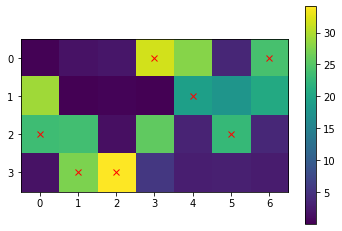

In [17]:
locals().update(dict(comparison.fn_rolonies.iloc[0]))
print("There's a rolony here with barcode",j,"but this simple method failed to find it.")
plt.imshow(bench.X[:,:,0,m1,m2].T)
plt.plot(*np.where(bench.codebook[:,:,j]),'rx');
plt.colorbar()

Its easy to see why the simple method failed to identify this spot -- there are actually TWO rolonies here, in the same place!  This confuses the simple method.

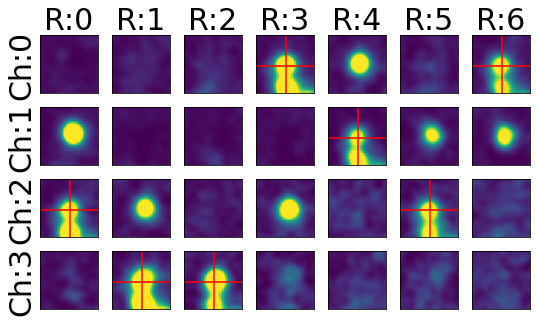

In [18]:

locals().update(dict(comparison.fn_rolonies.iloc[0]))
import bardensr.plotting
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,m1-10:m1+10,m2-10:m2+10],vmax=15)
    if bench.codebook[r,c,j]:
        plt.axhline(10,color='red')
        plt.axvline(10,color='red')
bardensr.plotting.plot_rbc(7,4,go,sz=1,sideways=True,notick=True)

### analyzing the data (the nonnegative-regression way)

Another way to analyze the data is to use nonnegative-regression.  In some ways this is similar to the way proposed above -- for each voxel and each barcode we identify a nonnegative density indicating how much that barcode is present at that location.  Then we can identify peaks in these densities to find rolonies.

In [80]:
bdresult=bardensr.singlefov.denselearner.build_density(bench.X,bench.codebook,use_tqdm_notebook=True)
densities_bardensr=bdresult.density

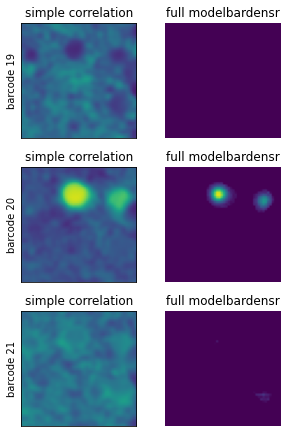

In [81]:
with bardensr.plotting.AnimAcross(sz=2,columns=2) as a:
    for j in [19,20,21]:
        a(f'simple correlation')
        plt.imshow(densities[0,25:75,25:75,j],vmin=0,vmax=1)
        plt.ylabel(f'barcode {j}')
        plt.xticks([]); plt.yticks([])
        
        a('full modelbardensr')
        plt.imshow(densities_bardensr[0,25:75,25:75,j],vmin=0,vmax=.5)
        plt.axis('off')

Note that the bardensr answers are much less noisy!  It also calculates some interpretable parameters, such as a gain parameter for each of the images:

Text(0, 0.5, 'channels')

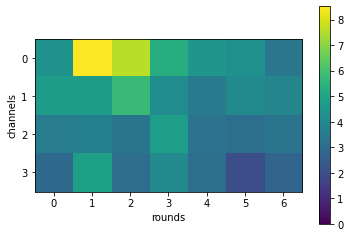

In [83]:
plt.imshow(bdresult.model.alpha.numpy().T,vmin=0)
plt.colorbar()
plt.xlabel("rounds")
plt.ylabel('channels')

For this dataset, the accuracy is not that different from the simple method though:

In [130]:
densities_bardensr=bdresult.density.copy()
densities_bardensr=densities_bardensr/(.01+np.median(densities_bardensr,axis=-1,keepdims=True))
bd_thresh=15
result_bardensr=bardensr.barcodesfirst.peak_call(densities_bardensr,3,bd_thresh)
comparison_bardensr=bench.fpfn(result_bardensr,5)
print("How many false positive?",comparison_bardensr.fp) 
print("How many false negatives?",comparison_bardensr.fn)

How many false positive? 7
How many false negatives? 6


In [132]:
densities_bardensr=bdresult.density.copy()
bd_thresh=.15
result_bardensr=bardensr.barcodesfirst.peak_call(densities_bardensr,3,bd_thresh)
comparison_bardensr=bench.fpfn(result_bardensr,5)
print("How many false positive?",comparison_bardensr.fp) 
print("How many false negatives?",comparison_bardensr.fn)

How many false positive? 7
How many false negatives? 6


Bardensr has an especially hard time with very dim spots.  Here's one it misses:

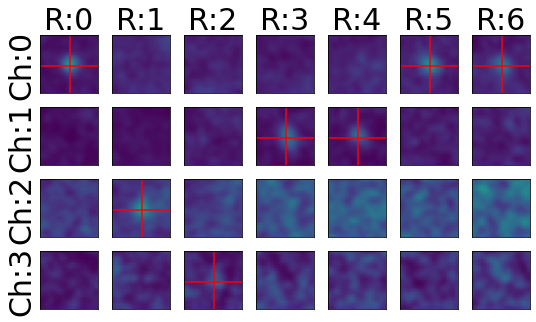

In [122]:
locals().update(dict(comparison_bardensr.fn_rolonies.iloc[1]))
import bardensr.plotting
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,m1-10:m1+10,m2-10:m2+10],vmin=0,vmax=10)
    if bench.codebook[r,c,j]:
        plt.axhline(10,color='red')
        plt.axvline(10,color='red')
bardensr.plotting.plot_rbc(7,4,go,sz=1,sideways=True,notick=True)

We can see that bardensr suspects there is some signal there, but it just isn't above the threshold:

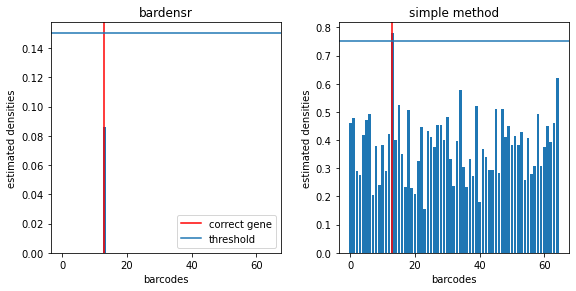

In [152]:
with bardensr.plotting.AnimAcross() as a:
    locals().update(dict(comparison_bardensr.fn_rolonies.iloc[1]))
    
    a('bardensr')
    plt.bar(range(bench.n_genes),densities_bardensr[0,m1,m2])
    plt.axvline(j,color='red',label='correct gene')
    plt.axhline(bd_thresh,color='C0',label='threshold')
    plt.legend()
    plt.ylabel('estimated densities')
    plt.xlabel('barcodes')
    plt.legend()
    
    a('simple method')
    plt.bar(range(bench.n_genes),densities[0,m1,m2])
    plt.axvline(j,color='red',label='correct gene')
    plt.axhline(thresh,color='C0')
    plt.ylabel('estimated densities')
    plt.xlabel('barcodes')

Here's a case where bardensr thinks there is something there -- but really there's not...

bardensr thinks barcode 13 is here, i.e. [0 2 3 1 1 0 0] -- but it is wrong


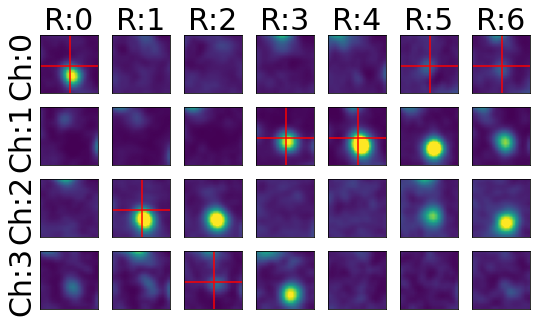

In [151]:
locals().update(dict(comparison_bardensr.fp_rolonies.iloc[1]))
import bardensr.plotting
def go(r,c,*args):
    plt.imshow(bench.X[r,c,0,m1-10:m1+10,m2-10:m2+10],vmin=0,vmax=30)
    if bench.codebook[r,c,j]:
        plt.axhline(10,color='red')
        plt.axvline(10,color='red')
bardensr.plotting.plot_rbc(7,4,go,sz=1,sideways=True,notick=True)

print('bardensr thinks barcode',j,'is here, i.e.',np.where(bench.codebook[:,:,j])[1],'-- but it is wrong')

It is easy to see why bardensr would get confused.  There is indeed some signal in all the images associated with this barcode.  However, this collection of images is actually better explained as a combination of barcodes 18 and 1.  The signal in the later rounds of channel 0 is very likely spurious.

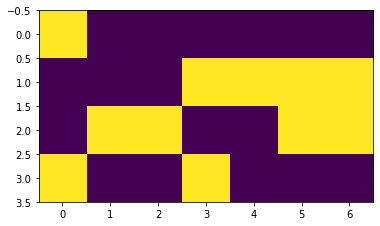

In [149]:
plt.imshow(bench.codebook[:,:,18].T+bench.codebook[:,:,1].T)